In [1]:
import os
import similaritymeasures
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.neighbors import DistanceMetric
import seaborn as sns
from scipy.spatial import minkowski_distance

import pandas as pd

In [2]:
def ade_matching(exp_data, num_data, p=2):
    r"""
    Compute the ADE by using matching used in Discrete Frechet Distance
    Compute the ADE between two N-D curves according to matching in
    [1]_. The Frechet distance has been defined as the walking dog problem.
    From Wikipedia: "In mathematics, the Frechet distance is a measure of
    similarity between curves that takes into account the location and
    ordering of the points along the curves. It is named after Maurice Frechet.
    https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance
    Parameters
    ----------
    exp_data : array_like
        Curve from your experimental data. exp_data is of (M, N) shape, where
        M is the number of data points, and N is the number of dimmensions
    num_data : array_like
        Curve from your numerical data. num_data is of (P, N) shape, where P
        is the number of data points, and N is the number of dimmensions
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.
    Returns
    -------
    df : float
        discrete Frechet distance
    References
    ----------
    .. [1] Thomas Eiter and Heikki Mannila. Computing discrete Frechet
        distance. Technical report, 1994.
        http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.937&rep=rep1&type=pdf
    """
    n = len(exp_data)
    m = len(num_data)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = minkowski_distance(exp_data[0], num_data[0], p=p)
    for i in range(1, n):
        ca[i, 0] = ca[i-1, 0]+ minkowski_distance(exp_data[i], num_data[0],
                                                      p=p)
    for j in range(1, m):
        ca[0, j] = ca[0, j-1]+ minkowski_distance(exp_data[0], num_data[j],
                                                      p=p)
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1])+minkowski_distance(exp_data[i], num_data[j], p=p)
    return ca[n-1, m-1]/max(n,m)



In [3]:
def get_commands(val_path):
    commands = []
    for episode in os.listdir(val_path):
        filename = os.path.join(val_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()
            commands.append(command)
    return commands

In [134]:
def get_scores(val_data_path, val_run_path, save_loc, episodes = None,subplots = False):
    os.makedirs(save_loc,exist_ok=True)
    frechet_dists = []
    fde_dists = []
    ade_dists = []
    ade_match_dists = []
    if episodes is None:
        episodes = list(range(50))
    if subplots != False:
        fig = plt.figure(figsize=(10,5))
        handles = []
        labels = []
    for i,episode in enumerate(episodes):
        if subplots != False:
            plt.subplot(subplots[i])
            print('subplotting')
        else:
            plt.figure(figsize=(10,10))
        episode = str(episode)
        filename = os.path.join(val_run_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        run_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_data_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        data_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_run_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()

        plt.plot(data_traj[:,0],data_traj[:,1],label='Ground Truth')
        plt.plot(run_traj[:,0],run_traj[:,1],label='Inference on Prediction')
        plt.scatter(data_traj[-1,0],data_traj[-1,1],s=100,label='Ground Truth - End Point')
        plt.scatter(run_traj[-1,0],run_traj[-1,1],s=100,label='Inference - End Point')
        plt.scatter(data_traj[0,0],data_traj[0,1],s=100,label='Starting Point')

        x_min = np.min(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_min = np.min(np.hstack([data_traj[:,1],run_traj[:,1]]))

        x_max = np.max(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_max = np.max(np.hstack([data_traj[:,1],run_traj[:,1]]))

        frechet_dists.append(similaritymeasures.frechet_dist(run_traj,data_traj))
        
        min_length = min(run_traj.shape[0],data_traj.shape[0])
        
        r_idx = np.arange(1,run_traj.shape[0]-1)
        np.random.shuffle(r_idx)
        r_idx = [0]+r_idx[:min_length-2].tolist()+[run_traj.shape[0]-1]
        r_idx = sorted(r_idx)
        run_traj_trimmed = run_traj[r_idx]

        d_idx = np.arange(1,data_traj.shape[0]-1)
        np.random.shuffle(d_idx)
        d_idx = [0]+d_idx[:min_length-2].tolist()+[data_traj.shape[0]-1]
        d_idx = sorted(d_idx)
        data_traj_trimmed = data_traj[d_idx]
        print(data_traj_trimmed.shape,run_traj_trimmed.shape)
        
        distances = np.sqrt(np.sum((data_traj_trimmed-run_traj_trimmed)**2,axis=1))
        ade = np.sum(distances)/min_length
        ade_dists.append(ade)
        
        ade_match_dists.append(ade_matching(run_traj,data_traj))


        fde_dists.append(similaritymeasures.distance.euclidean(data_traj[-1,:],run_traj[-1,:]))
        
        size = max(x_max-x_min+10,y_max-y_min+10)
        if x_max-x_min>y_max-y_min:
            excess_size = size-(y_max-y_min)
            excess_size/=2
            plt.xlim(x_min-5, x_max+5)
            plt.ylim(y_min-excess_size, y_max+excess_size)
        else:
            excess_size = size-(x_max-x_min)
            excess_size/=2
            plt.xlim(x_min-excess_size, x_max+excess_size)
            plt.ylim(y_min-5, y_max+5)
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.title(command)

#         plt.legend()
        if subplots == False:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
            plt.savefig(os.path.join(save_loc,episode)+'.png') 
        
        print(f'Episode {episode}: {command}')
        print(f'Frechet Distance: {frechet_dists[-1]}')
        print(f'FDE Distance: {fde_dists[-1]}')
        print(f'ADE Distance: {ade_dists[-1]}')
        print(f'ADE Matched Distance: {ade_match_dists[-1]}')
    #     print(f'Curve Length Measure: {cl_measures[-1]}')
        if subplots == False:
            plt.show()
    if subplots != False:
        lines_labels = [ ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        lines = lines[:5]
        labels = labels[:5]
#         fig.legend(lines, labels)
        
        print(lines,labels)
        
        fig.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        plt.savefig(os.path.join(save_loc,'final')+'.png') 
        plt.show()
        
    return frechet_dists, fde_dists, ade_dists, ade_match_dists

In [5]:
# ! scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_runs.zip
# ! scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
# ! scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_dual2_fbf_mask.zip /ssd_scratch/cvit/varunc
# unzip /ssd_scratch/cvit/varunc/val_convlstm.zip

scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_runs.zip
scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_convlstm.zip
scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_framebyframe.zip
scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_fbf2.zip
scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_temp_convattn.zip
scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_fbf_network2.zip

scp varunc@ada:/share3/varunc/val_dual_fgf_mask.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_mask.zip
scp varunc@ada:/share3/varunc/val_dual_fgf_trajectory.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_trajectory.zip


(170, 3) (170, 3)
Episode 0: Go straight and stop before the traffic light.
Frechet Distance: 26.111845491426653
FDE Distance: 26.111845491426653
ADE Distance: 41.2555774241194
ADE Matched Distance: 5.127950789358234


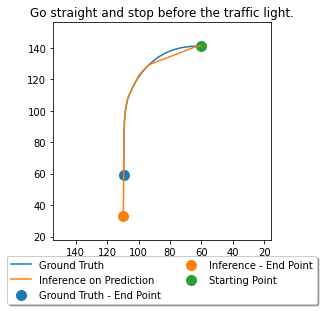

(136, 3) (136, 3)
Episode 1: go straight and take a right
Frechet Distance: 6.409774368995845
FDE Distance: 6.409774368995845
ADE Distance: 4.132724146503285
ADE Matched Distance: 1.5706127697530465


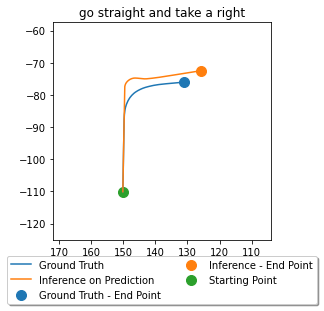

(66, 3) (66, 3)
Episode 2: Shift to the left lane and stop at the intersection.
Frechet Distance: 12.082260518632788
FDE Distance: 12.082260518632788
ADE Distance: 12.456613162066022
ADE Matched Distance: 3.760792268781853


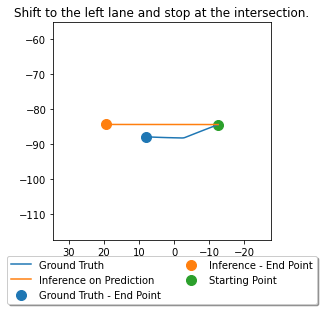

(45, 3) (45, 3)
Episode 3: Stop after crossing the stop signboard
Frechet Distance: 2.7664610068414364
FDE Distance: 2.766461006841437
ADE Distance: 1.3940112041249355
ADE Matched Distance: 0.4542789519034148


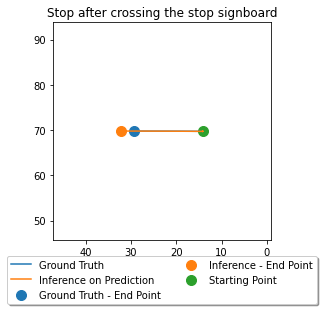

(60, 3) (60, 3)
Episode 4: Park on the roadside after you have crossed the bus stop
Frechet Distance: 3.334854446656641
FDE Distance: 3.3348544466566405
ADE Distance: 1.607679695545969
ADE Matched Distance: 0.21886810386670763


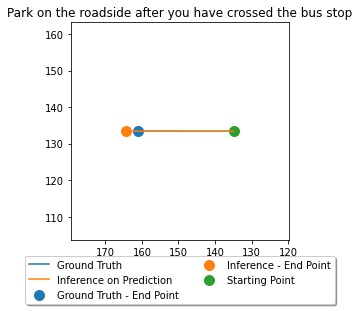

(332, 3) (332, 3)
Episode 5: Take the next right turn.
Frechet Distance: 9.918604998670695
FDE Distance: 9.918604998670695
ADE Distance: 3.426003413622177
ADE Matched Distance: 0.4090016854781849


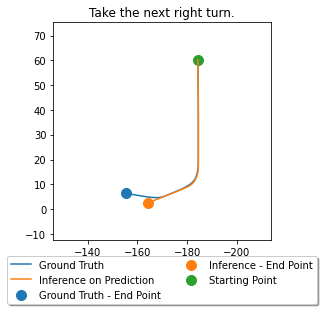

(80, 3) (80, 3)
Episode 6: Stop in front of the garbage dumpsters.
Frechet Distance: 17.072058310386677
FDE Distance: 17.072058310386677
ADE Distance: 14.725407776860754
ADE Matched Distance: 4.850736024870975


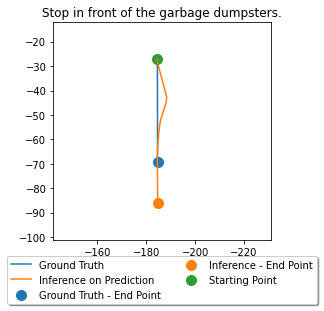

(70, 3) (70, 3)
Episode 7: change to left lane
Frechet Distance: 11.234243026607567
FDE Distance: 11.234243026607567
ADE Distance: 4.192145318823151
ADE Matched Distance: 2.9163633893781697


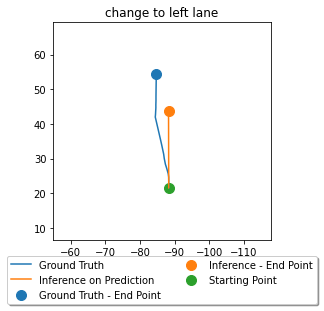

(113, 3) (113, 3)
Episode 8: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 23.26119392554721
FDE Distance: 23.26119392554721
ADE Distance: 14.686180019339346
ADE Matched Distance: 6.064259444144584


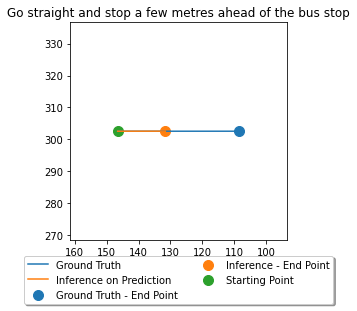

(38, 3) (38, 3)
Episode 9: Stop near the signboard
Frechet Distance: 9.440485504095543
FDE Distance: 9.440485504095543
ADE Distance: 4.778638673816069
ADE Matched Distance: 1.7951156115785956


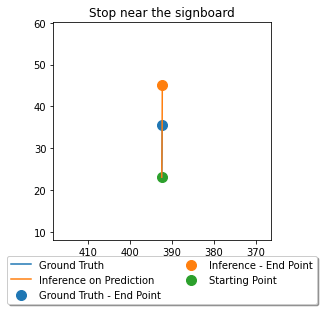

(71, 3) (71, 3)
Episode 10: stop by the lamp post
Frechet Distance: 5.769687585316607
FDE Distance: 5.769687585316607
ADE Distance: 2.412044902717128
ADE Matched Distance: 0.6504436517824256


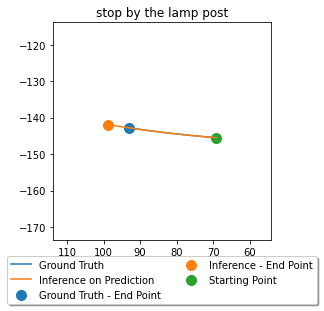

(45, 3) (45, 3)
Episode 11: After crossing the blue car come to a stop
Frechet Distance: 2.2496643059118075
FDE Distance: 2.2496643059118075
ADE Distance: 1.3451252282233037
ADE Matched Distance: 0.11379863268316082


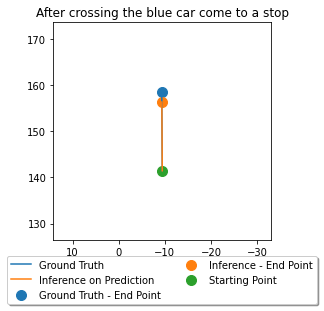

(73, 3) (73, 3)
Episode 12: Drive straight till the intersection and then turn left
Frechet Distance: 13.804164257040698
FDE Distance: 13.804164257040698
ADE Distance: 8.890232026842261
ADE Matched Distance: 0.42504100814483164


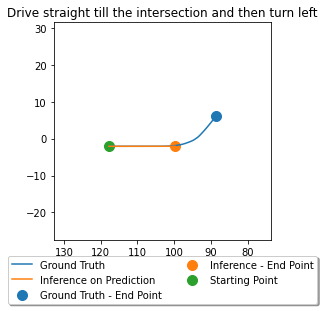

(61, 3) (61, 3)
Episode 13: Drive to the corner and go right
Frechet Distance: 6.641624991224376
FDE Distance: 6.641624991224376
ADE Distance: 7.497696488055743
ADE Matched Distance: 0.7248410949372083


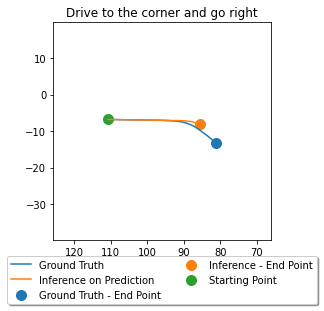

(66, 3) (66, 3)
Episode 14: Turn right from the intersection.
Frechet Distance: 7.521698756749053
FDE Distance: 7.521698756749053
ADE Distance: 4.6012384977254674
ADE Matched Distance: 0.9440076470747767


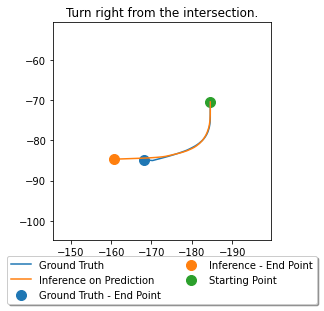

(44, 3) (44, 3)
Episode 15: Stop near the red shelters
Frechet Distance: 16.376811999900273
FDE Distance: 16.376811999900273
ADE Distance: 4.411157194349732
ADE Matched Distance: 2.7320624764373767


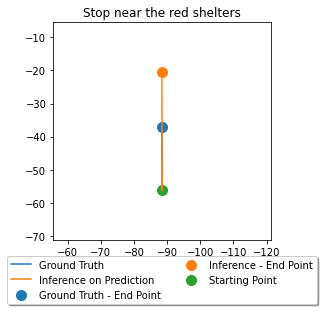

(55, 3) (55, 3)
Episode 16: Drive straight till you see a red coloured board
Frechet Distance: 8.76290896626611
FDE Distance: 8.76290896626611
ADE Distance: 5.029544720560894
ADE Matched Distance: 0.7156071867620573


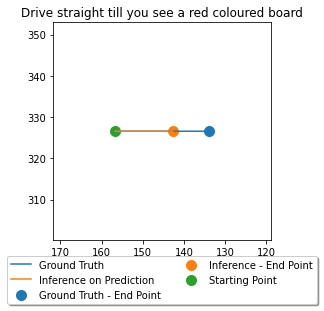

(142, 3) (142, 3)
Episode 17: take right and stop near the speed limit sign
Frechet Distance: 14.540158873750967
FDE Distance: 14.540158873750967
ADE Distance: 8.320739416507775
ADE Matched Distance: 2.1624867439565585


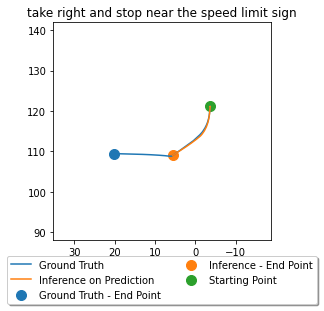

(81, 3) (81, 3)
Episode 18: take a right turn and stop across the bench on left
Frechet Distance: 0.7166695875518984
FDE Distance: 0.7166695875518984
ADE Distance: 7.157681084987231
ADE Matched Distance: 0.15807829024916945


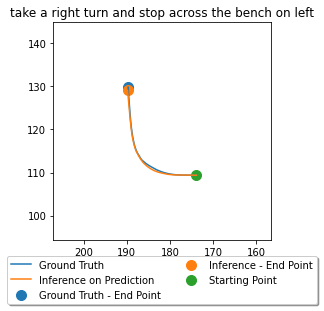

(58, 3) (58, 3)
Episode 19: Stop before the next right turn.
Frechet Distance: 32.55587197896258
FDE Distance: 32.55587197896258
ADE Distance: 16.607566281285475
ADE Matched Distance: 9.423114114792808


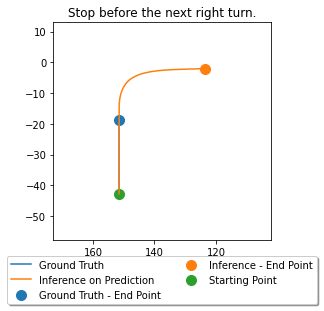

(38, 3) (38, 3)
Episode 20: Park just ahead of the speed signboard
Frechet Distance: 8.583039742608017
FDE Distance: 8.583039742608017
ADE Distance: 1.7860584272901652
ADE Matched Distance: 1.31437907904765


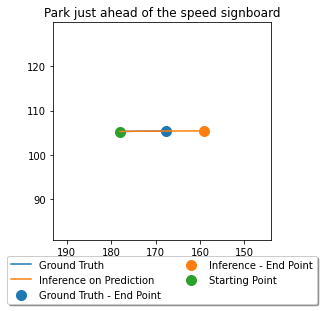

(59, 3) (59, 3)
Episode 21: Turn right and stop near the bus stop.
Frechet Distance: 2.7446696386591745
FDE Distance: 2.7446696386591745
ADE Distance: 1.4996936718608929
ADE Matched Distance: 0.5059493093631044


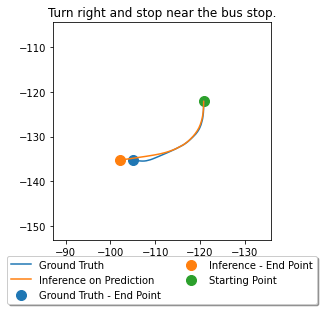

(340, 3) (340, 3)
Episode 22: Wait at the traffic light then go straight.
Frechet Distance: 86.74084336381058
FDE Distance: 86.74084336381058
ADE Distance: 18.44514409695685
ADE Matched Distance: 13.326183835845066


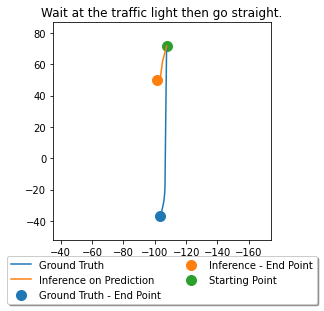

(57, 3) (57, 3)
Episode 23: Turn right from the intersection
Frechet Distance: 1.1752202891395593
FDE Distance: 1.1752004228828945
ADE Distance: 1.908408684043676
ADE Matched Distance: 0.2761978171832063


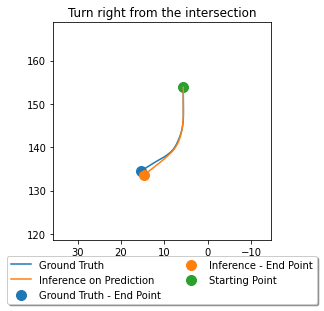

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 3.2317066771617986
FDE Distance: 3.2317066771617986
ADE Distance: 1.596020042282319
ADE Matched Distance: 0.25397958711337576


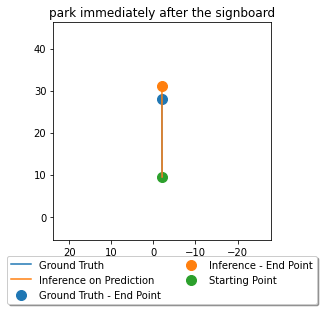

(452, 3) (452, 3)
Episode 25: Wait for the signal to turn green and continue straight
Frechet Distance: 25.57962031409034
FDE Distance: 25.57962031409034
ADE Distance: 3.3480512435045604
ADE Matched Distance: 1.2037599886639607


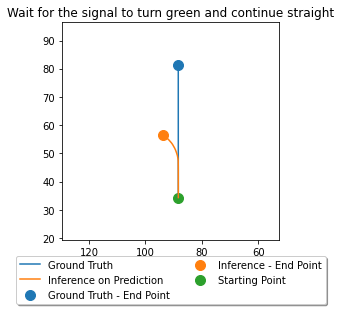

(42, 3) (42, 3)
Episode 26: park beside the red volkswagen
Frechet Distance: 12.707549556605851
FDE Distance: 12.707549556605851
ADE Distance: 4.899043387783821
ADE Matched Distance: 2.2830185027656587


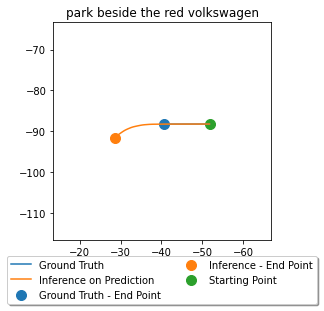

(107, 3) (107, 3)
Episode 27: Go straight and stop next to the grey gate.
Frechet Distance: 5.846886480329105
FDE Distance: 5.846886480329105
ADE Distance: 7.83678140072326
ADE Matched Distance: 0.22476231689606482


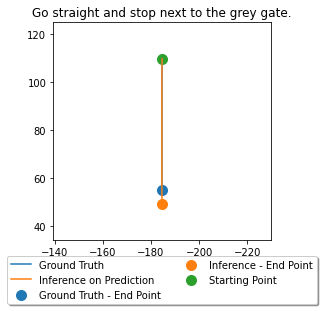

(136, 3) (136, 3)
Episode 28: stop at the bus stand in front
Frechet Distance: 3.8256378487020752
FDE Distance: 3.8256378487020752
ADE Distance: 14.19865089419161
ADE Matched Distance: 0.17858555690216346


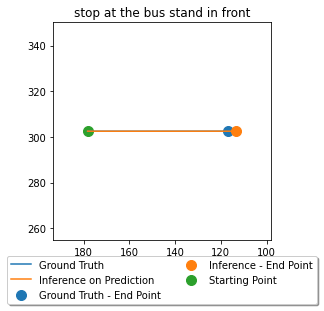

(63, 3) (63, 3)
Episode 29: Drive towards the bus stop and park after crossing it
Frechet Distance: 13.310310079965095
FDE Distance: 13.310310079965095
ADE Distance: 6.49704395704159
ADE Matched Distance: 1.3668733248750997


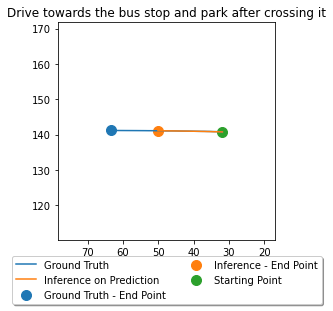

(36, 3) (36, 3)
Episode 30: Park near the hut visible on the right
Frechet Distance: 9.66544172924443
FDE Distance: 9.66544172924443
ADE Distance: 4.103861271293382
ADE Matched Distance: 1.6543062056431428


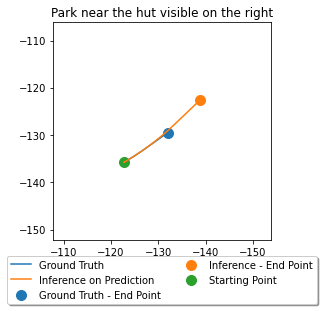

(104, 3) (104, 3)
Episode 31: go straight and take a left
Frechet Distance: 56.50831523077798
FDE Distance: 56.50831523077798
ADE Distance: 30.899584038606857
ADE Matched Distance: 23.73539048485986


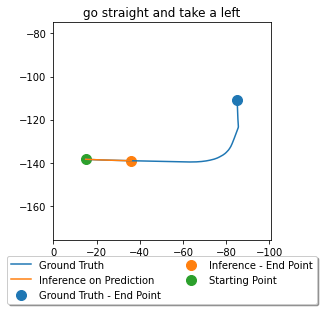

(94, 3) (94, 3)
Episode 32: Take a left from the interection.
Frechet Distance: 3.765229522877658
FDE Distance: 3.765229522877658
ADE Distance: 10.475058232598123
ADE Matched Distance: 2.0354057837136073


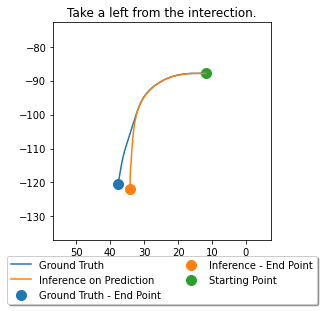

(109, 3) (109, 3)
Episode 33: stop beside the black suv
Frechet Distance: 2.1969193377628256
FDE Distance: 2.1969193377628256
ADE Distance: 7.616525253191801
ADE Matched Distance: 0.12423717109026729


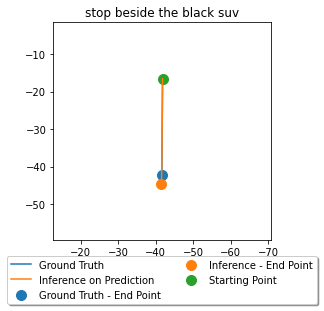

(654, 3) (654, 3)
Episode 34: take a right at the traffic lights and then take a left
Frechet Distance: 66.81778550635848
FDE Distance: 66.81778550635848
ADE Distance: 26.794499125216603
ADE Matched Distance: 22.708138798195602


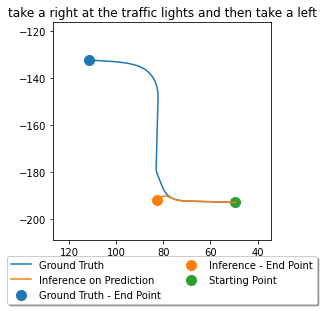

(105, 3) (105, 3)
Episode 35: take a right at the intersection
Frechet Distance: 7.410823894093601
FDE Distance: 7.410823894093601
ADE Distance: 7.28528189119263
ADE Matched Distance: 1.1299083279375313


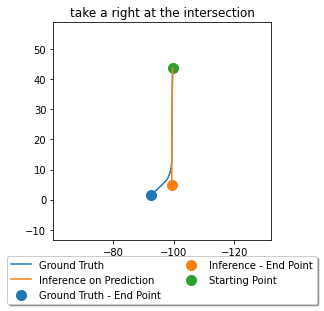

(47, 3) (47, 3)
Episode 36: Stop as soon as you encounter a white car
Frechet Distance: 3.801777204143639
FDE Distance: 3.8017772041436384
ADE Distance: 1.8444265104397415
ADE Matched Distance: 1.0719182022180593


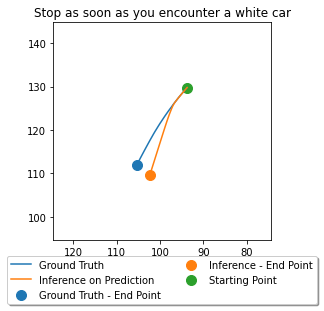

(102, 3) (102, 3)
Episode 37: Turn right from the crossroads ahead.
Frechet Distance: 53.85665965765187
FDE Distance: 53.85665965765187
ADE Distance: 29.602309704392276
ADE Matched Distance: 20.826374536658008


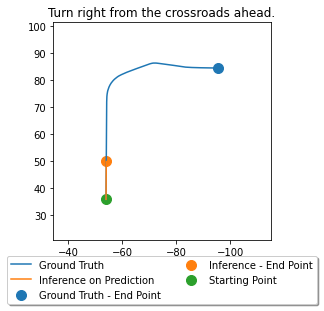

(128, 3) (128, 3)
Episode 38: Drive straight then turn right.
Frechet Distance: 35.58646343573618
FDE Distance: 35.58646343573618
ADE Distance: 26.886323220987006
ADE Matched Distance: 12.204056191898108


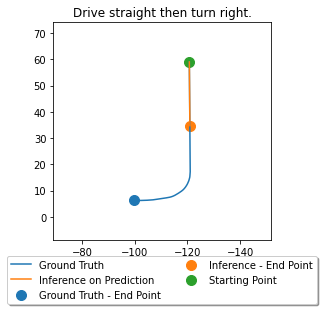

(437, 3) (437, 3)
Episode 39: Turn left and stop next to the bus stop.
Frechet Distance: 43.56896854301628
FDE Distance: 43.56896854301628
ADE Distance: 4.9606978196457785
ADE Matched Distance: 2.6402514970535127


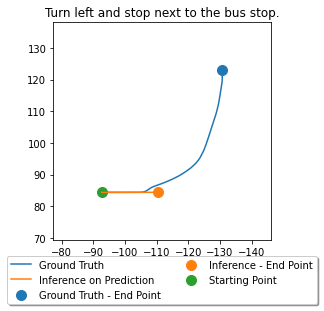

(127, 3) (127, 3)
Episode 40: Turn left from the intersection
Frechet Distance: 14.917346932727456
FDE Distance: 14.917346932727456
ADE Distance: 6.3568281797490975
ADE Matched Distance: 0.9231577648198713


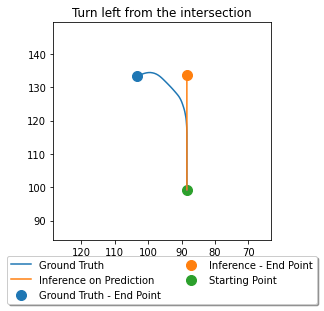

(42, 3) (42, 3)
Episode 41: Stop near the scooty
Frechet Distance: 2.2248366364196506
FDE Distance: 2.2248366364196506
ADE Distance: 1.2605830547617398
ADE Matched Distance: 0.12880145675087418


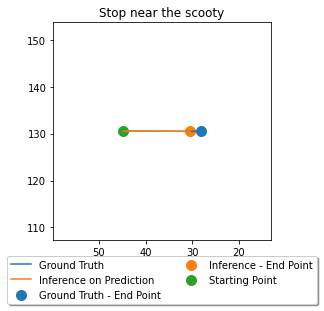

(114, 3) (114, 3)
Episode 42: Turn left from the next crossroads.
Frechet Distance: 51.34624511149129
FDE Distance: 51.34624511149129
ADE Distance: 21.984382679310524
ADE Matched Distance: 10.522560881353568


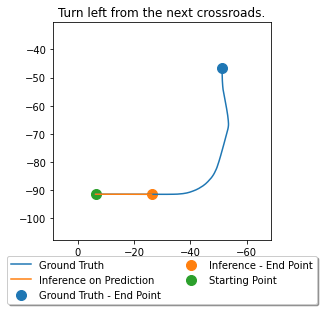

(45, 3) (45, 3)
Episode 43: Park near the red signboard
Frechet Distance: 0.5139187571147539
FDE Distance: 0.22427531875362688
ADE Distance: 1.1613950557769934
ADE Matched Distance: 0.08849377913037716


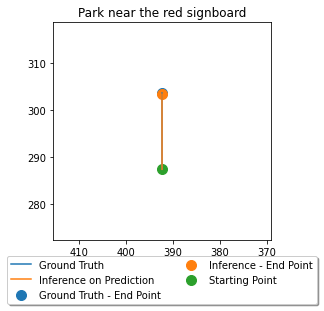

(80, 3) (80, 3)
Episode 44: Drive to the intersection and turn left
Frechet Distance: 0.7396500641066885
FDE Distance: 0.7396500641066887
ADE Distance: 9.83663938199226
ADE Matched Distance: 0.06356950235761988


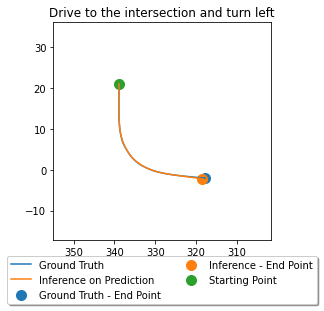

(96, 3) (96, 3)
Episode 45: Drive straight from the next crossroads.
Frechet Distance: 68.45545005535746
FDE Distance: 68.45545005535746
ADE Distance: 30.440721743366748
ADE Matched Distance: 24.87372803946943


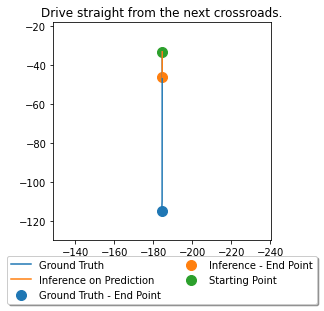

(156, 3) (156, 3)
Episode 46: Turn right and park near the sidewalk.
Frechet Distance: 66.41540404304233
FDE Distance: 66.41540404304233
ADE Distance: 52.86648013569093
ADE Matched Distance: 42.99233287725821


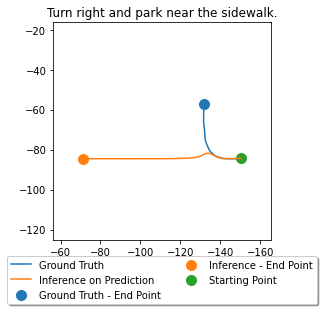

(66, 3) (66, 3)
Episode 47: Change lanes and stop at the junction.
Frechet Distance: 3.925613171783614
FDE Distance: 3.925613171783614
ADE Distance: 3.128564745956153
ADE Matched Distance: 1.8636331241104038


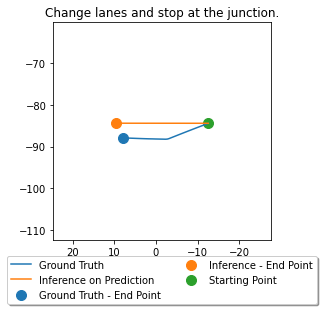

(66, 3) (66, 3)
Episode 48: Turn right from the crossroads.
Frechet Distance: 1.9252116247595719
FDE Distance: 1.9252116247595719
ADE Distance: 1.7541342133416766
ADE Matched Distance: 0.22654007186225503


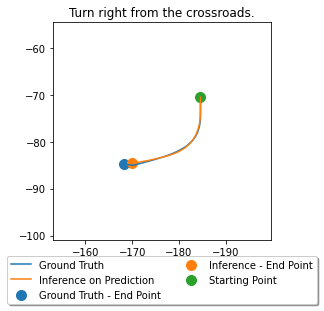

(80, 3) (80, 3)
Episode 49: Take a left from the intersection ahead.
Frechet Distance: 3.8564965994752956
FDE Distance: 3.8564965994752956
ADE Distance: 5.1832933358235325
ADE Matched Distance: 0.45353017107913196


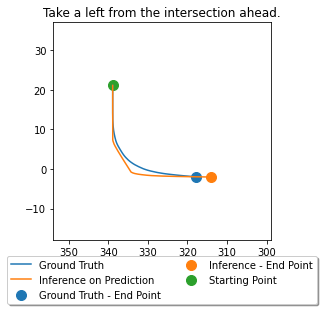

In [6]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val5_conv3d/'
save_loc = '../trajectories_conv3d/'

frechet_conv3d,fde_conv3d,ade_conv3d, ade_matched_conv3d = get_scores(val_data_path, val_run_path, save_loc)

subplotting
(45, 3) (45, 3)
Episode 11: After crossing the blue car come to a stop
Frechet Distance: 2.2496643059118075
FDE Distance: 2.2496643059118075
ADE Distance: 2.2260000615720372
ADE Matched Distance: 0.11379863268316082
subplotting
(66, 3) (66, 3)
Episode 14: Turn right from the intersection.
Frechet Distance: 7.521698756749053
FDE Distance: 7.521698756749053
ADE Distance: 4.718412440708598
ADE Matched Distance: 0.9440076470747767
[<matplotlib.lines.Line2D object at 0x147d3207f750>, <matplotlib.lines.Line2D object at 0x147d3207f9d0>, <matplotlib.collections.PathCollection object at 0x147d3207fa10>, <matplotlib.collections.PathCollection object at 0x147d3207fcd0>, <matplotlib.collections.PathCollection object at 0x147d320136d0>] ['Ground Truth', 'Inference on Prediction', 'Ground Truth - End Point', 'Inference - End Point', 'Starting Point']


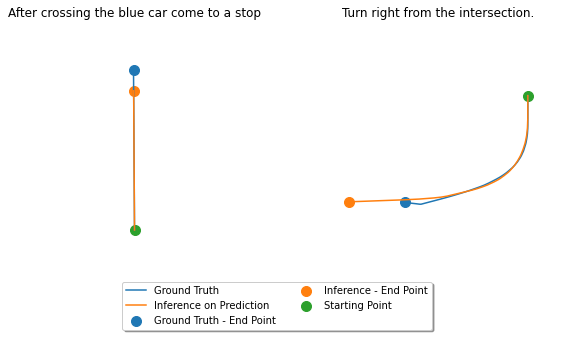

([2.2496643059118075, 7.521698756749053],
 [2.2496643059118075, 7.521698756749053],
 [2.2260000615720372, 4.718412440708598],
 [0.11379863268316082, 0.9440076470747767])

In [135]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val5_conv3d/'
save_loc = '../trajectories_temp'

get_scores(val_data_path, val_run_path, save_loc,episodes = [11,14],subplots=[121,122])

(80, 3) (80, 3)
Episode 0: Go straight and stop before the traffic light.
Frechet Distance: 90.59249842920809
FDE Distance: 90.59249842920809
ADE Distance: 44.33715923340456
ADE Matched Distance: 38.12549675972528


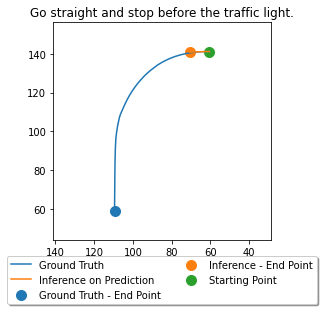

(136, 3) (136, 3)
Episode 1: go straight and take a right
Frechet Distance: 6.593041440555822
FDE Distance: 6.593041440555822
ADE Distance: 3.5402183203237167
ADE Matched Distance: 0.4778890316451603


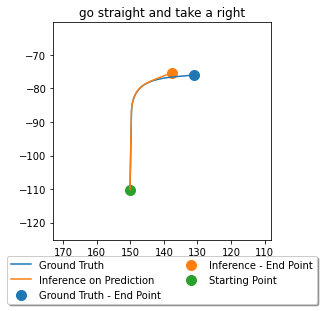

(66, 3) (66, 3)
Episode 2: Shift to the left lane and stop at the intersection.
Frechet Distance: 110.20466395654934
FDE Distance: 110.20466395654935
ADE Distance: 56.213525753491844
ADE Matched Distance: 49.960543804708806


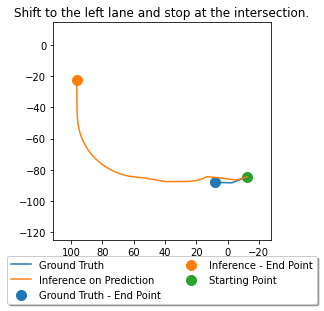

(45, 3) (45, 3)
Episode 3: Stop after crossing the stop signboard
Frechet Distance: 8.748302839894835
FDE Distance: 8.748302839894835
ADE Distance: 3.6021535273635816
ADE Matched Distance: 1.7168678975069946


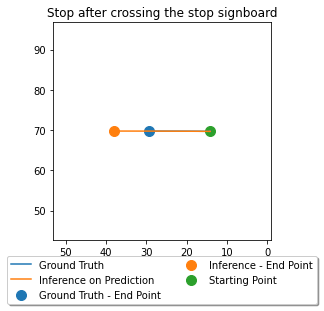

(60, 3) (60, 3)
Episode 4: Park on the roadside after you have crossed the bus stop
Frechet Distance: 8.673508621547523
FDE Distance: 8.673508621547523
ADE Distance: 4.580938404654109
ADE Matched Distance: 0.6274035456188378


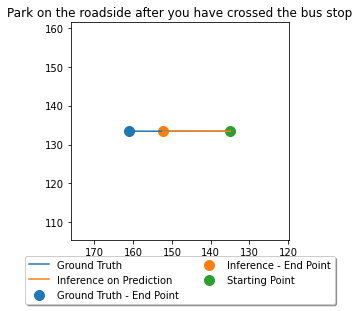

(332, 3) (332, 3)
Episode 5: Take the next right turn.
Frechet Distance: 9.857383769447859
FDE Distance: 9.857383769447859
ADE Distance: 4.491435391750542
ADE Matched Distance: 0.26161018942738196


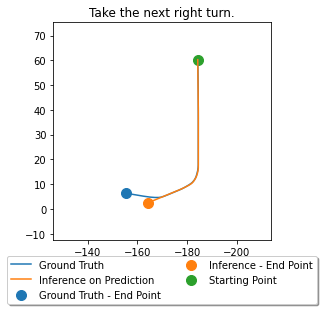

(80, 3) (80, 3)
Episode 6: Stop in front of the garbage dumpsters.
Frechet Distance: 12.044128793338531
FDE Distance: 12.04412879333853
ADE Distance: 6.536295533178586
ADE Matched Distance: 0.9107284283302849


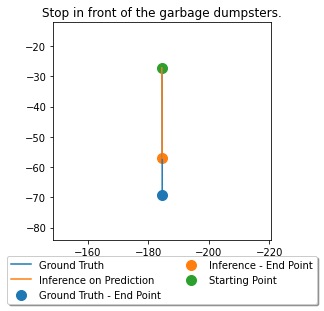

(70, 3) (70, 3)
Episode 7: change to left lane
Frechet Distance: 111.26862644858433
FDE Distance: 97.93182110518646
ADE Distance: 85.30894205104198
ADE Matched Distance: 69.39660931203876


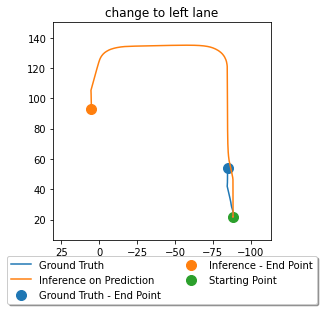

(100, 3) (100, 3)
Episode 8: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 27.89035985656598
FDE Distance: 27.89035985656598
ADE Distance: 15.43238201888007
ADE Matched Distance: 9.596284604529597


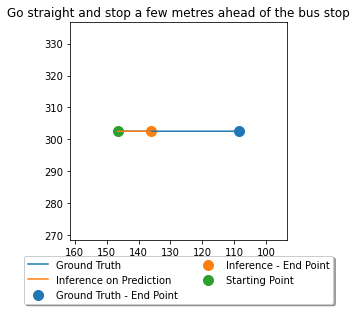

(38, 3) (38, 3)
Episode 9: Stop near the signboard
Frechet Distance: 9.440485504095543
FDE Distance: 9.440485504095543
ADE Distance: 3.0292762484066897
ADE Matched Distance: 1.815176453494246


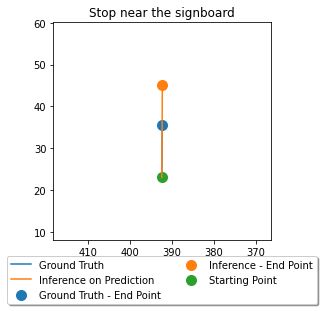

(71, 3) (71, 3)
Episode 10: stop by the lamp post
Frechet Distance: 7.213482416101908
FDE Distance: 7.213482416101908
ADE Distance: 4.792371242055338
ADE Matched Distance: 0.9232464695174448


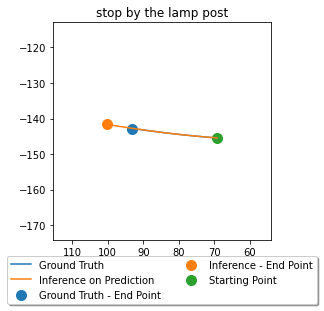

(45, 3) (45, 3)
Episode 11: After crossing the blue car come to a stop
Frechet Distance: 2.950150073685143
FDE Distance: 2.950150073685143
ADE Distance: 1.9060669053528339
ADE Matched Distance: 0.45810006396688113


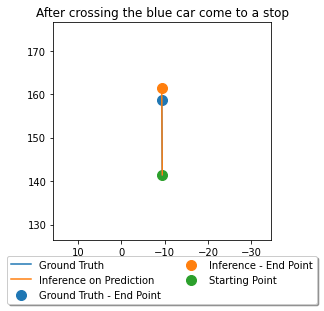

(73, 3) (73, 3)
Episode 12: Drive straight till the intersection and then turn left
Frechet Distance: 212.33916789385594
FDE Distance: 212.33916789385597
ADE Distance: 57.40396159651441
ADE Matched Distance: 56.61101716895551


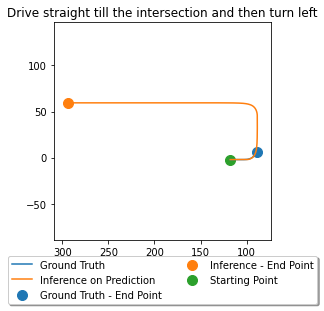

(61, 3) (61, 3)
Episode 13: Drive to the corner and go right
Frechet Distance: 7.284234243189723
FDE Distance: 7.284234243189723
ADE Distance: 3.753355028955301
ADE Matched Distance: 1.033664733155864


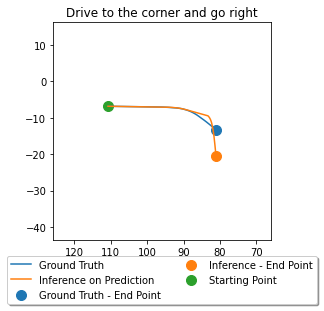

(66, 3) (66, 3)
Episode 14: Turn right from the intersection.
Frechet Distance: 8.425640053997611
FDE Distance: 8.425640053997611
ADE Distance: 3.154552474136442
ADE Matched Distance: 1.1563228977490998


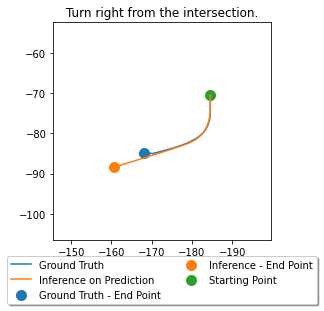

(44, 3) (44, 3)
Episode 15: Stop near the red shelters
Frechet Distance: 3.0568580218909256
FDE Distance: 3.0568580218909256
ADE Distance: 1.4991485502625381
ADE Matched Distance: 0.4512224573532643


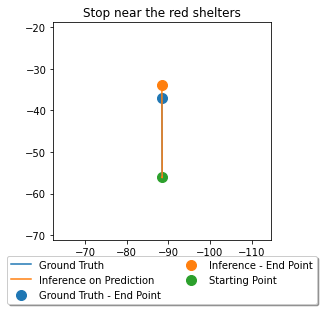

(55, 3) (55, 3)
Episode 16: Drive straight till you see a red coloured board
Frechet Distance: 7.241333073812641
FDE Distance: 7.241333073812641
ADE Distance: 3.2610475849415432
ADE Matched Distance: 1.0574568100842312


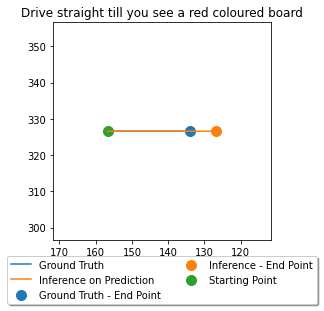

(142, 3) (142, 3)
Episode 17: take right and stop near the speed limit sign
Frechet Distance: 12.282180049642605
FDE Distance: 12.282180049642605
ADE Distance: 7.676123043985439
ADE Matched Distance: 1.5615661245064072


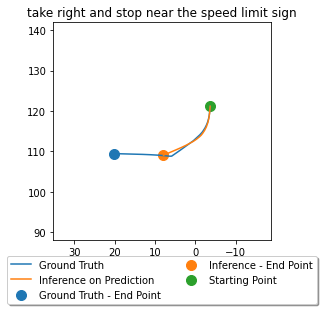

(81, 3) (81, 3)
Episode 18: take a right turn and stop across the bench on left
Frechet Distance: 22.17168104788207
FDE Distance: 22.171681047882068
ADE Distance: 8.505983131711215
ADE Matched Distance: 4.605109812045859


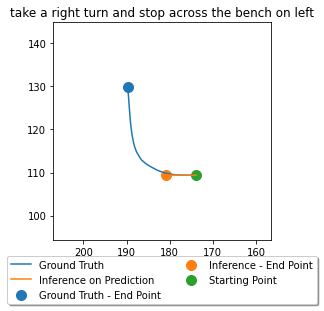

(58, 3) (58, 3)
Episode 19: Stop before the next right turn.
Frechet Distance: 20.66114902892529
FDE Distance: 20.66114902892529
ADE Distance: 10.599339454935075
ADE Matched Distance: 5.1854949459189825


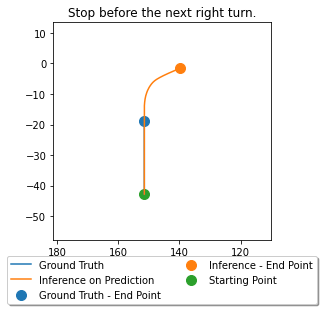

(38, 3) (38, 3)
Episode 20: Park just ahead of the speed signboard
Frechet Distance: 6.0435577338959865
FDE Distance: 6.0435577338959865
ADE Distance: 2.7484784810939615
ADE Matched Distance: 0.8693093575044933


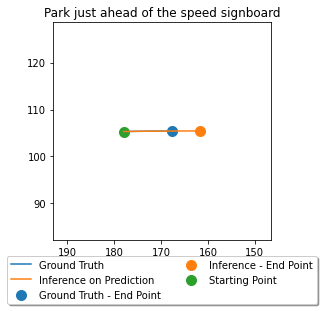

(59, 3) (59, 3)
Episode 21: Turn right and stop near the bus stop.
Frechet Distance: 9.601379397928957
FDE Distance: 9.601379397928957
ADE Distance: 3.3349477049455265
ADE Matched Distance: 1.487926577538819


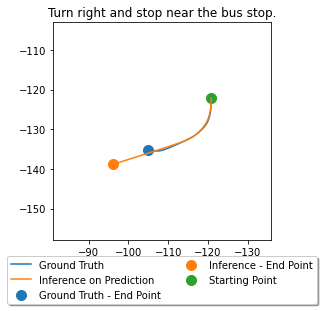

(340, 3) (340, 3)
Episode 22: Wait at the traffic light then go straight.
Frechet Distance: 81.68961399386156
FDE Distance: 81.68961399386156
ADE Distance: 18.63595815992361
ADE Matched Distance: 13.289811604631645


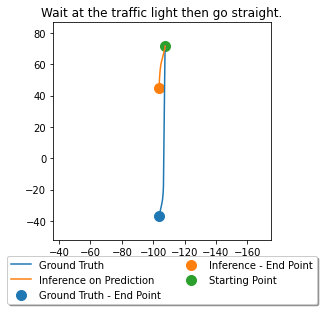

(57, 3) (57, 3)
Episode 23: Turn right from the intersection
Frechet Distance: 2.745710896999294
FDE Distance: 2.745710896999294
ADE Distance: 2.454496382214943
ADE Matched Distance: 0.4114767589843977


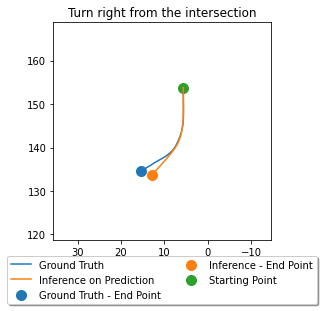

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 5.416578033494437
FDE Distance: 5.416578033494437
ADE Distance: 2.818960307704955
ADE Matched Distance: 0.3072191214663793


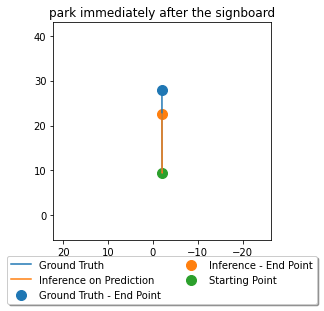

(452, 3) (452, 3)
Episode 25: Wait for the signal to turn green and continue straight
Frechet Distance: 9.976829553741247
FDE Distance: 9.976829553741249
ADE Distance: 4.205498003138936
ADE Matched Distance: 0.2068663644532079


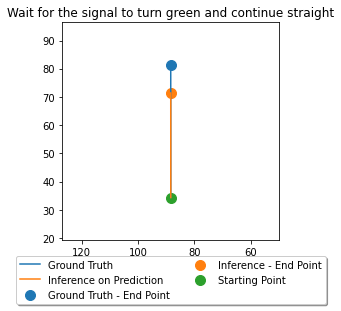

(42, 3) (42, 3)
Episode 26: park beside the red volkswagen
Frechet Distance: 7.640141151050459
FDE Distance: 7.640141151050459
ADE Distance: 3.7334384929037063
ADE Matched Distance: 1.464359315564731


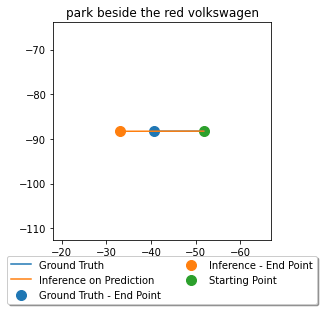

(107, 3) (107, 3)
Episode 27: Go straight and stop next to the grey gate.
Frechet Distance: 33.04093377144283
FDE Distance: 33.04093377144283
ADE Distance: 20.40878863894576
ADE Matched Distance: 10.375052635484204


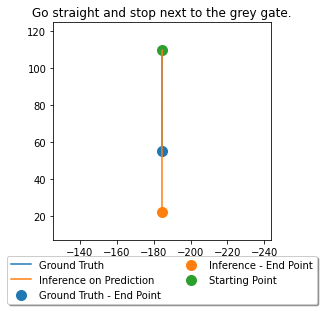

(136, 3) (136, 3)
Episode 28: stop at the bus stand in front
Frechet Distance: 12.694986326538997
FDE Distance: 12.694986326538997
ADE Distance: 12.002878496606009
ADE Matched Distance: 0.3728577272737833


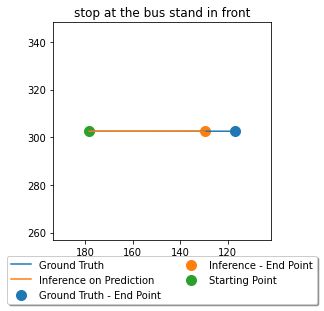

(63, 3) (63, 3)
Episode 29: Drive towards the bus stop and park after crossing it
Frechet Distance: 11.050943856338177
FDE Distance: 11.050943856338177
ADE Distance: 5.1737258814494655
ADE Matched Distance: 0.8917312239667224


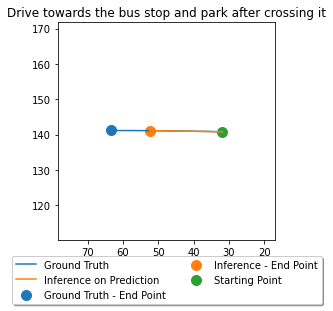

(36, 3) (36, 3)
Episode 30: Park near the hut visible on the right
Frechet Distance: 33.60811375293736
FDE Distance: 33.60811375293736
ADE Distance: 12.164417461362833
ADE Matched Distance: 9.939220412383998


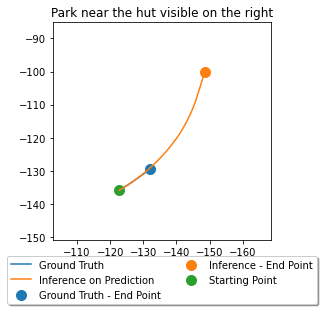

(239, 3) (239, 3)
Episode 31: go straight and take a left
Frechet Distance: 122.82551301348737
FDE Distance: 115.54064018168543
ADE Distance: 93.31037680530339
ADE Matched Distance: 65.55419631072262


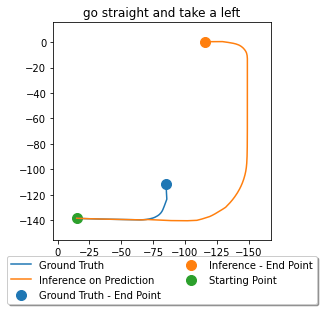

(94, 3) (94, 3)
Episode 32: Take a left from the interection.
Frechet Distance: 134.84526360600918
FDE Distance: 134.84526360600918
ADE Distance: 49.69259588259555
ADE Matched Distance: 37.31790903569385


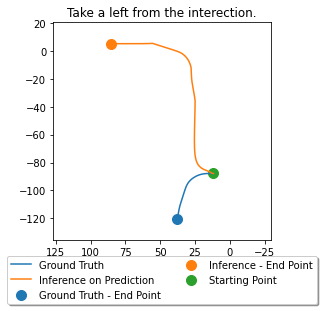

(97, 3) (97, 3)
Episode 33: stop beside the black suv
Frechet Distance: 12.093724567996773
FDE Distance: 12.093724567996773
ADE Distance: 8.315829695980716
ADE Matched Distance: 3.7020578214108


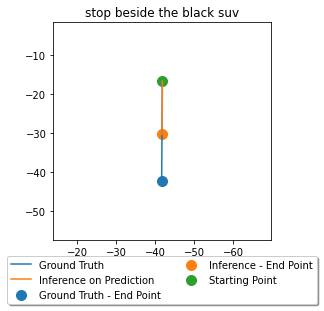

(1426, 3) (1426, 3)
Episode 34: take a right at the traffic lights and then take a left
Frechet Distance: 70.85528282725416
FDE Distance: 63.85660965295794
ADE Distance: 37.136653323031396
ADE Matched Distance: 33.965216744236


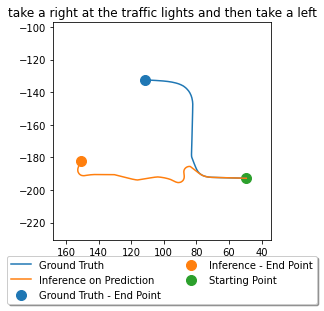

(105, 3) (105, 3)
Episode 35: take a right at the intersection
Frechet Distance: 6.554961188149346
FDE Distance: 6.554961188149346
ADE Distance: 21.822285963146435
ADE Matched Distance: 4.359888907531277


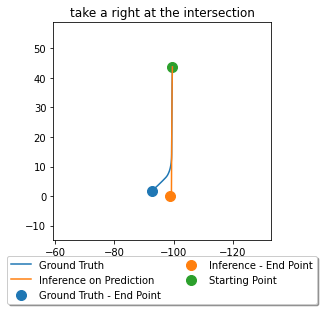

(47, 3) (47, 3)
Episode 36: Stop as soon as you encounter a white car
Frechet Distance: 1.7791922735494983
FDE Distance: 1.7791922735494983
ADE Distance: 1.6412085022302043
ADE Matched Distance: 0.1326939923322312


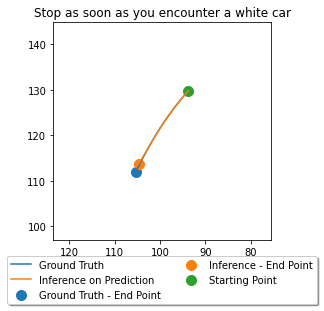

(242, 3) (242, 3)
Episode 37: Turn right from the crossroads ahead.
Frechet Distance: 121.4962114463668
FDE Distance: 121.4962114463668
ADE Distance: 65.55942285723141
ADE Matched Distance: 51.47422937830128


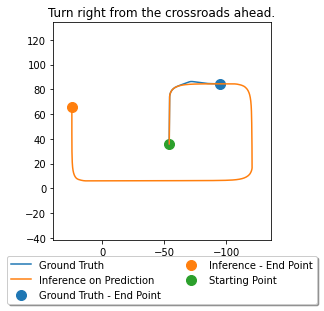

(133, 3) (133, 3)
Episode 38: Drive straight then turn right.
Frechet Distance: 34.274938702584535
FDE Distance: 34.274938702584535
ADE Distance: 26.99275309122063
ADE Matched Distance: 10.74610090810285


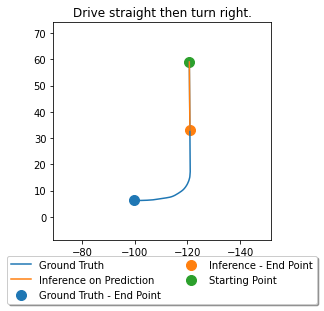

(651, 3) (651, 3)
Episode 39: Turn left and stop next to the bus stop.
Frechet Distance: 233.97924088846418
FDE Distance: 209.47856446505406
ADE Distance: 128.27977093177037
ADE Matched Distance: 130.40493401075196


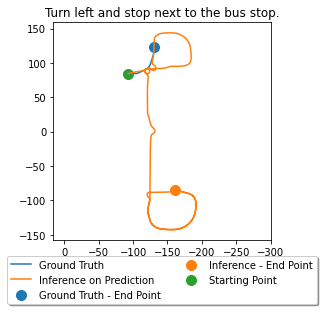

(127, 3) (127, 3)
Episode 40: Turn left from the intersection
Frechet Distance: 244.39947508143743
FDE Distance: 93.07048065639373
ADE Distance: 155.84782117908605
ADE Matched Distance: 146.99573957110343


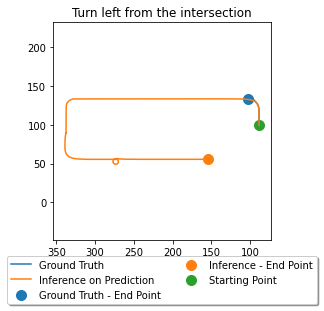

(42, 3) (42, 3)
Episode 41: Stop near the scooty
Frechet Distance: 9.548865569860112
FDE Distance: 9.548865569860112
ADE Distance: 4.90651864729411
ADE Matched Distance: 1.984399995057886


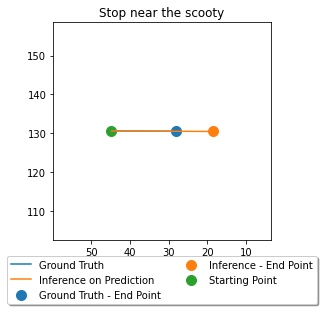

(310, 3) (310, 3)
Episode 42: Turn left from the next crossroads.
Frechet Distance: 68.01248068617676
FDE Distance: 68.01248068617676
ADE Distance: 15.252388244387825
ADE Matched Distance: 11.44636870718119


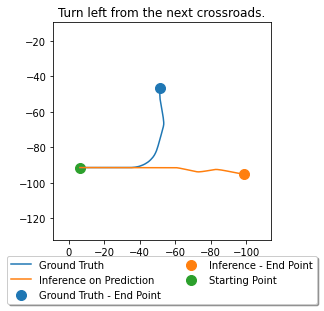

(45, 3) (45, 3)
Episode 43: Park near the red signboard
Frechet Distance: 6.615020819992471
FDE Distance: 6.615020819992471
ADE Distance: 2.2209198154573198
ADE Matched Distance: 0.22239555949307196


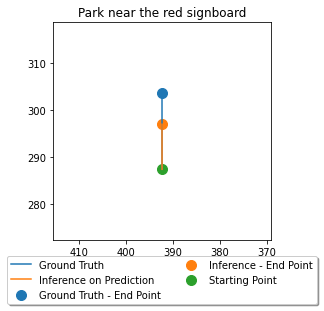

(80, 3) (80, 3)
Episode 44: Drive to the intersection and turn left
Frechet Distance: 92.45029253644533
FDE Distance: 92.45029253644533
ADE Distance: 29.71211911009356
ADE Matched Distance: 16.796870960679794


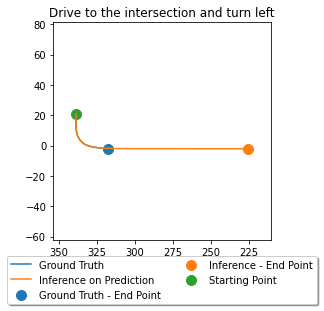

(150, 3) (150, 3)
Episode 45: Drive straight from the next crossroads.
Frechet Distance: 40.37902684154216
FDE Distance: 40.37902684154216
ADE Distance: 20.211768900728032
ADE Matched Distance: 7.69220351296961


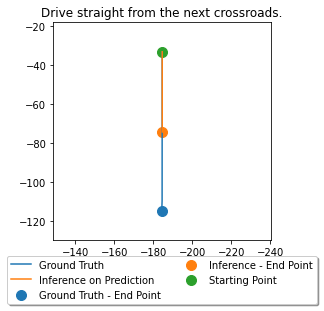

(116, 3) (116, 3)
Episode 46: Turn right and park near the sidewalk.
Frechet Distance: 19.28893217869272
FDE Distance: 19.28893217869272
ADE Distance: 4.482506168245635
ADE Matched Distance: 3.0171993779129567


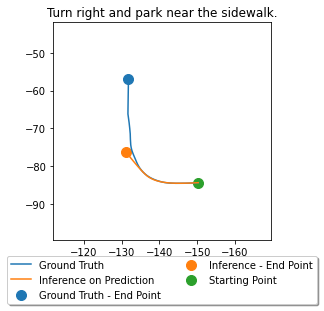

(66, 3) (66, 3)
Episode 47: Change lanes and stop at the junction.
Frechet Distance: 14.020959723274968
FDE Distance: 14.020959723274968
ADE Distance: 6.140964630710473
ADE Matched Distance: 3.9336619343876427


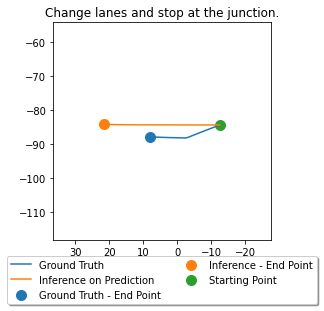

(66, 3) (66, 3)
Episode 48: Turn right from the crossroads.
Frechet Distance: 8.425640053997611
FDE Distance: 8.425640053997611
ADE Distance: 6.359792467837494
ADE Matched Distance: 1.0640463584106292


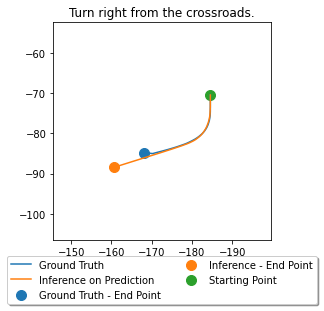

(80, 3) (80, 3)
Episode 49: Take a left from the intersection ahead.
Frechet Distance: 42.98475162308692
FDE Distance: 42.98475162308692
ADE Distance: 9.702173742217317
ADE Matched Distance: 5.326366602790473


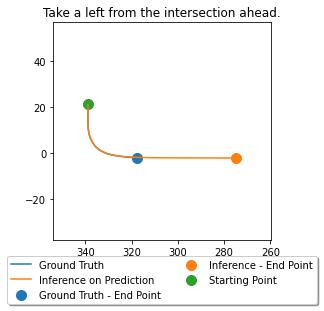

In [7]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val5_vit/'
save_loc = '../trajectories_vit/'

frechet_vit,fde_vit,ade_vit, ade_matched_vit = get_scores(val_data_path, val_run_path, save_loc)

In [141]:
import math
trunc = lambda x: math.trunc(1000 * x) / 1000;

In [8]:
frechet_df = pd.DataFrame({'Conv3D':frechet_conv3d,'VIT':frechet_vit})
fde_df = pd.DataFrame({'Conv3D':fde_conv3d,'VIT':fde_vit})
ade_df = pd.DataFrame({'Conv3D':ade_conv3d,'VIT':ade_vit})
ade_match_df = pd.DataFrame({'Conv3D':ade_matched_conv3d,'VIT':ade_matched_vit})

In [9]:
frechet_metric = pd.DataFrame([frechet_df.mean(),frechet_df.std(),frechet_df.median()],index=['Mean','STD','Median'])
frechet_metric['Metric'] = 'Frechet'

fde_metric = pd.DataFrame([fde_df.mean(),fde_df.std(),fde_df.median()],index=['Mean','STD','Median'])
fde_metric['Metric'] = 'FDE'

ade_metric = pd.DataFrame([ade_df.mean(),ade_df.std(),ade_df.median()],index=['Mean','STD','Median'])
ade_metric['Metric'] = 'ADE'

ade_match_metric = pd.DataFrame([ade_match_df.mean(),ade_match_df.std(),ade_match_df.median()],index=['Mean','STD','Median'])
ade_match_metric['Metric'] = 'ADE Match'

joined = pd.concat([frechet_metric,fde_metric,ade_metric,ade_match_metric])

joined['Measure'] = joined.index

joined = joined.set_index(['Metric','Measure'])

In [10]:
joined.T

Metric     Frechet                              FDE                        \
Measure       Mean        STD     Median       Mean        STD     Median   
Conv3D   17.836302  21.491849   9.101697  17.830508  21.496653   9.101697   
VIT      43.945549  60.559106  12.187952  39.876548  51.379565  12.187952   

Metric         ADE                       ADE Match                      
Measure       Mean        STD    Median       Mean        STD   Median  
Conv3D   10.307690  11.312478  5.770061   4.728350   8.511337  1.25907  
VIT      22.097875  33.108710  7.106209  16.433682  31.232047  2.50080

In [147]:
joined.applymap(trunc).to_csv('joined.csv')

Text(0.5, 1.0, 'Freschet Distance')

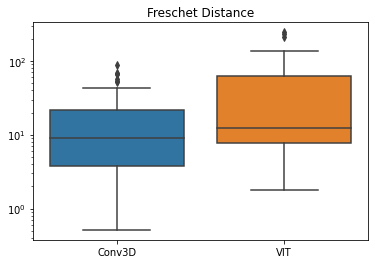

In [11]:
g = sns.boxplot(data=frechet_df)
g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance')

Text(0.5, 1.0, 'FDE Distance')

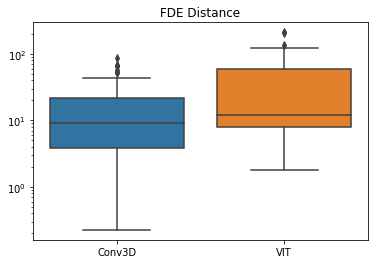

In [12]:
g = sns.boxplot(data=fde_df)
g.set_yscale("log")
plt.title('FDE Distance')

Text(0.5, 1.0, 'ADE Distance')

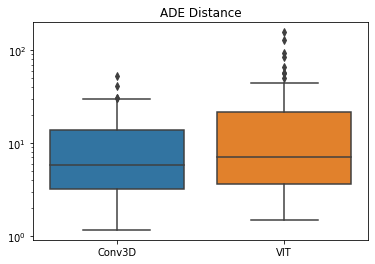

In [13]:
g = sns.boxplot(data=ade_df)
g.set_yscale("log")
plt.title('ADE Distance')

Text(0.5, 1.0, 'ADE Match Distance')

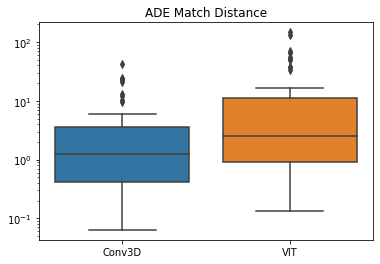

In [14]:
g = sns.boxplot(data=ade_match_df)
g.set_yscale("log")
plt.title('ADE Match Distance')

In [15]:
def get_ablations(commands):
    out = dict()
    for i,command in enumerate(commands):
        print(command)
        c_types = input('Type:')
        c_types = [ c.strip() for c in c_types.split(',')]
        for c_type in c_types:
            if c_type in out:
                out[c_type].append(i)
            else:
                out[c_type] = [i]
    return out

In [16]:
commands = get_commands('/ssd_scratch/cvit/varunc/carla_data/val/')

In [17]:
stop_turn = get_ablations(commands)

Stop after crossing the stop signboard


KeyboardInterrupt: Interrupted by user

In [18]:
stop_turn = {'stop': [0, 2, 4, 6, 9, 11, 12, 13, 15, 17, 18, 22, 24, 25, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 46, 47], 'left': [1, 3, 8, 10, 14, 15, 19, 26, 34, 42], 'right': [5, 7, 19, 21, 24, 27, 28, 32, 36, 37, 44, 45, 48, 49], 'straight': [16, 20, 23]}

In [19]:
stop_frechet_df = frechet_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_fde_df = fde_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_df = ade_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_match_df = ade_match_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)


stop_frechet_metric = pd.DataFrame([stop_frechet_df.mean(),stop_frechet_df.std(),stop_frechet_df.median()],index=['Mean','STD','Median'])
stop_frechet_metric['Metric'] = 'Frechet'

stop_fde_metric = pd.DataFrame([stop_fde_df.mean(),stop_fde_df.std(),stop_fde_df.median()],index=['Mean','STD','Median'])
stop_fde_metric['Metric'] = 'FDE'

stop_ade_metric = pd.DataFrame([stop_ade_df.mean(),stop_ade_df.std(),stop_ade_df.median()],index=['Mean','STD','Median'])
stop_ade_metric['Metric'] = 'ADE'

stop_ade_match_metric = pd.DataFrame([stop_ade_match_df.mean(),stop_ade_match_df.std(),stop_ade_match_df.median()],index=['Mean','STD','Median'])
stop_ade_match_metric['Metric'] = 'ADE Match'

stop_joined = pd.concat([stop_frechet_metric,stop_fde_metric,stop_ade_metric,stop_ade_match_metric])

stop_joined['Measure'] = stop_joined.index
stop_joined['Command Type'] = 'Stopping Based'
stop_joined = stop_joined.set_index(['Metric','Measure'])
stop_joined

Conv3D        VIT    Command Type
Metric    Measure                                      
Frechet   Mean     17.326682  53.981311  Stopping Based
          STD      21.375390  72.795143  Stopping Based
          Median    9.665442  12.282180  Stopping Based
FDE       Mean     17.316695  47.667016  Stopping Based
          STD      21.383593  60.744939  Stopping Based
          Median    9.665442  12.282180  Stopping Based
ADE       Mean     10.724657  26.614002  Stopping Based
          STD      12.428624  39.105454  Stopping Based
          Median    7.157681   7.676123  Stopping Based
ADE Match Mean      4.444001  20.895273  Stopping Based
          STD       9.003296  37.588336  Stopping Based
          Median    1.366873   3.702058  Stopping Based

In [20]:
turn_frechet_df = frechet_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_fde_df = fde_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_df = ade_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_match_df = ade_match_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)


turn_frechet_metric = pd.DataFrame([turn_frechet_df.mean(),turn_frechet_df.std(),turn_frechet_df.median()],index=['Mean','STD','Median'])
turn_frechet_metric['Metric'] = 'Frechet'

turn_fde_metric = pd.DataFrame([turn_fde_df.mean(),turn_fde_df.std(),turn_fde_df.median()],index=['Mean','STD','Median'])
turn_fde_metric['Metric'] = 'FDE'

turn_ade_metric = pd.DataFrame([turn_ade_df.mean(),turn_ade_df.std(),turn_ade_df.median()],index=['Mean','STD','Median'])
turn_ade_metric['Metric'] = 'ADE'

turn_ade_match_metric = pd.DataFrame([turn_ade_match_df.mean(),turn_ade_match_df.std(),turn_ade_match_df.median()],index=['Mean','STD','Median'])
turn_ade_match_metric['Metric'] = 'ADE Match'

turn_joined = pd.concat([turn_frechet_metric,turn_fde_metric,turn_ade_metric,turn_ade_match_metric])

turn_joined['Measure'] = turn_joined.index

turn_joined['Command Type'] = 'Turning Based'

turn_joined = turn_joined.set_index(['Metric','Measure'])
turn_joined

Conv3D        VIT   Command Type
Metric    Measure                                     
Frechet   Mean     17.970466  36.416590  Turning Based
          STD      21.371984  40.996674  Turning Based
          Median    6.965737  16.678068  Turning Based
FDE       Mean     17.970466  35.569278  Turning Based
          STD      21.371984  39.775306  Turning Based
          Median    6.965737  16.678068  Turning Based
ADE       Mean     10.017345  17.524459  Turning Based
          STD       9.300756  21.721663  Turning Based
          Median    5.041168  10.150757  Turning Based
ADE Match Mean      5.033972  11.398932  Turning Based
          STD       7.565082  18.248139  Turning Based
          Median    1.321265   3.451181  Turning Based

In [21]:
type_joined = pd.concat([stop_joined.reset_index(),turn_joined.reset_index()])
type_joined = type_joined.pivot_table(index=['Command Type','Metric'],columns='Measure',sort=False)
type_joined

Conv3D                             VIT  \
Measure                        Mean    Median        STD       Mean   
Command Type   Metric                                                 
Stopping Based Frechet    17.326682  9.665442  21.375390  53.981311   
               FDE        17.316695  9.665442  21.383593  47.667016   
               ADE        10.724657  7.157681  12.428624  26.614002   
               ADE Match   4.444001  1.366873   9.003296  20.895273   
Turning Based  Frechet    17.970466  6.965737  21.371984  36.416590   
               FDE        17.970466  6.965737  21.371984  35.569278   
               ADE        10.017345  5.041168   9.300756  17.524459   
               ADE Match   5.033972  1.321265   7.565082  11.398932   

                                                
Measure                      Median        STD  
Command Type   Metric                           
Stopping Based Frechet    12.282180  72.795143  
               FDE        12.282180  60.744939  
               ADE         7.676123  39.105454  
               ADE Match   3.702058  37.588336  
Turning Based  Frechet    16.678068  40.996674  
               FDE        16.678068  39.775306  
               ADE        10.150757  21.721663  
               ADE Match   3.451181  18.248139

In [143]:
type_joined.applymap(trunc).to_csv('type_joined.csv')

In [22]:
len_commands = [len(s.split()) for s in commands]

In [23]:
len_commands
length_commands = dict()
for i,len_c in enumerate(len_commands):
    if len_c in length_commands:
        length_commands[len_c].append(i)
    else:
        length_commands[len_c] = [i]


In [24]:
length_commands

{6: [0, 1, 14, 23, 34, 37, 38, 45, 48],
 9: [2, 15, 17, 26, 31, 40, 44],
 5: [3, 5, 7, 13, 18, 21, 22, 25, 27, 39, 43, 49],
 7: [4, 8, 10, 24, 28, 33, 35, 46],
 4: [6, 29, 42],
 12: [9, 19],
 8: [11, 16, 36, 47],
 11: [12, 32],
 10: [20, 30, 41]}

In [25]:
command_vals = dict()
for i,len_c in enumerate(len_commands):
    if len_c in command_vals:
        command_vals[len_c].append({'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_matched_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   })
    else:
        command_vals[len_c] = [{'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   }]


In [26]:
command_vals

{6: [{'Conv3D': {'frechet': 26.111845491426653,
    'ade_match': 41.2555774241194,
    'ade': 41.2555774241194,
    'fde': 26.111845491426653},
   'VIT': {'frechet': 90.59249842920809,
    'ade_match': 38.12549675972528,
    'ade': 44.33715923340456,
    'fde': 90.59249842920809}},
  {'Conv3D': {'frechet': 6.409774368995845,
    'ade_match': 1.5706127697530465,
    'ade': 4.132724146503285,
    'fde': 6.409774368995845},
   'VIT': {'frechet': 6.593041440555822,
    'ade_match': 0.4778890316451603,
    'ade': 3.5402183203237167,
    'fde': 6.593041440555822}},
  {'Conv3D': {'frechet': 7.521698756749053,
    'ade_match': 0.9440076470747767,
    'ade': 4.6012384977254674,
    'fde': 7.521698756749053},
   'VIT': {'frechet': 8.425640053997611,
    'ade_match': 1.1563228977490998,
    'ade': 3.154552474136442,
    'fde': 8.425640053997611}},
  {'Conv3D': {'frechet': 1.1752202891395593,
    'ade_match': 0.2761978171832063,
    'ade': 1.908408684043676,
    'fde': 1.1752004228828945},
   'VIT

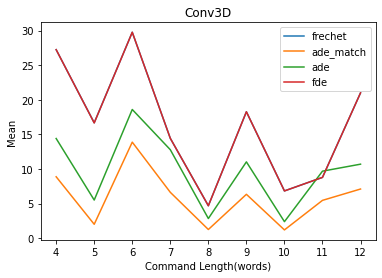

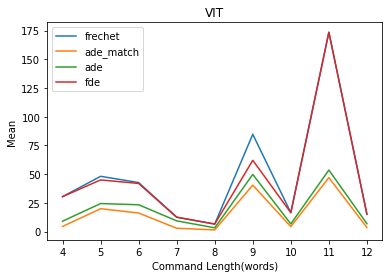

In [27]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.mean([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Mean')
    plt.xlabel('Command Length(words)')
    plt.show()

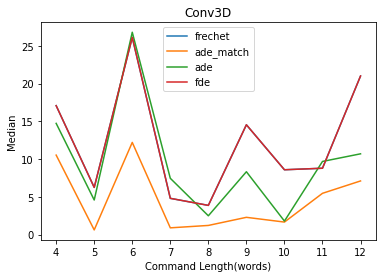

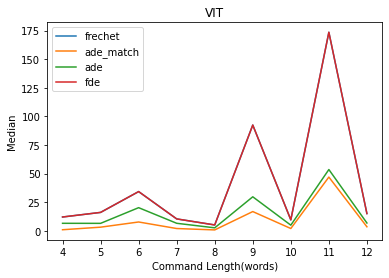

In [28]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

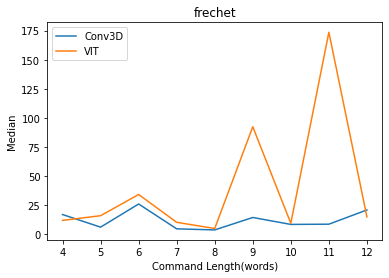

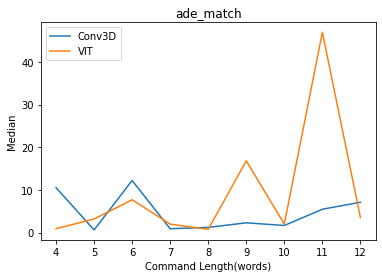

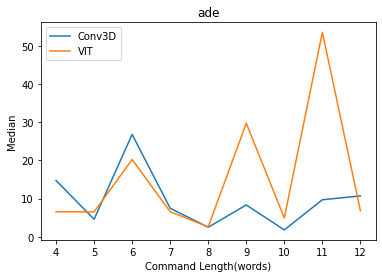

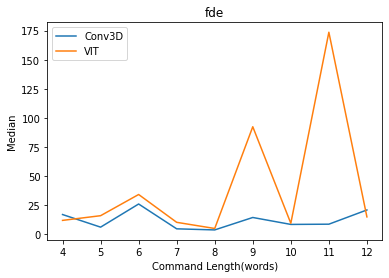

In [29]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for metric in ['frechet','ade_match','ade','fde']:
    plt.figure()
    for model in ['Conv3D','VIT']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = model)
    plt.title(metric)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

In [30]:
sub_command_count = get_ablations(commands)

Stop after crossing the stop signboard
Type:1
go straight and take a left
Type:2
After crossing the blue car come to a stop
Type:1
Turn left from the intersection
Type:1
Change lanes and stop at the junction.
Type:2
Drive straight then turn right.
Type:1
Stop near the signboard
Type:1
Turn right from the crossroads.
Type:1
Drive to the intersection and turn left
Type:2
Go straight and stop a few metres ahead of the bus stop
Type:1
Take a left from the intersection ahead.
Type:1
Park near the hut visible on the right
Type:1
Park on the roadside after you have crossed the bus stop
Type:1
park immediately after the signboard
Type:1
Take a left from the interection.
Type:1
Turn left and stop next to the bus stop.
Type:2
Wait at the traffic light then go straight.
Type:2
Stop as soon as you encounter a white car
Type:1
stop beside the black suv
Type:1
take a right at the traffic lights and then take a left
Type:2
Wait for the signal to turn green and continue straight
Type:2
Take the next r

In [33]:
sub_command_count = {'1': [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 29, 31, 33, 34, 35, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49], '2': [1, 4, 8, 15, 16, 19, 20, 24, 26, 28, 30, 32, 36, 40, 41, 44]}

In [34]:
target_type = get_ablations(commands)

Stop after crossing the stop signboard
Type:infra
go straight and take a left
Type:road
After crossing the blue car come to a stop
Type:auto
Turn left from the intersection
Type:road
Change lanes and stop at the junction.
Type:road
Drive straight then turn right.
Type:road
Stop near the signboard
Type:infra
Turn right from the crossroads.
Type:road
Drive to the intersection and turn left
Type:road
Go straight and stop a few metres ahead of the bus stop
Type:infra
Take a left from the intersection ahead.
Type:road
Park near the hut visible on the right
Type:infra
Park on the roadside after you have crossed the bus stop
Type:infra
park immediately after the signboard
Type:infra
Take a left from the interection.
Type:road
Turn left and stop next to the bus stop.
Type:road, infra
Wait at the traffic light then go straight.
Type:road
Stop as soon as you encounter a white car
Type:auto
stop beside the black suv
Type:auto
take a right at the traffic lights and then take a left
Type:road
Wait 

In [76]:
target_type = {'infrastructure': [0, 6, 9, 11, 12, 13, 15, 25, 31, 32, 33, 35, 36, 39, 40, 41, 43, 44, 46], 'road/traffic light': [1, 3, 4, 5, 7, 8, 10, 14, 15, 16, 19, 20, 21, 23, 24, 26, 27, 28, 30, 32, 34, 36, 37, 38, 40, 42, 44, 45, 47, 48, 49], 'automobile': [2, 17, 18, 22, 29]}

In [77]:
subcommands_frechet_df = dict()
subcommands_fde_df = dict()
subcommands_ade_df = dict()
subcommands_ade_match_df = dict()
subcommands_frechet_metric = dict()
subcommands_fde_metric = dict()
subcommands_ade_metric = dict()
subcommands_ade_match_metric = dict()
subcommands_joined = dict()


for k in sub_command_count.keys():
    subcommands_frechet_df[k] = frechet_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_fde_df[k] = fde_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_df[k] = ade_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_match_df[k] = ade_match_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)


    subcommands_frechet_metric[k] = pd.DataFrame([subcommands_frechet_df[k].mean(),subcommands_frechet_df[k].std(),subcommands_frechet_df[k].median()],index=['Mean','STD','Median'])
    subcommands_frechet_metric[k]['Metric'] = 'Frechet'

    subcommands_fde_metric[k] = pd.DataFrame([subcommands_fde_df[k].mean(),subcommands_fde_df[k].std(),subcommands_fde_df[k].median()],index=['Mean','STD','Median'])
    subcommands_fde_metric[k]['Metric'] = 'FDE'

    subcommands_ade_metric[k] = pd.DataFrame([subcommands_ade_df[k].mean(),subcommands_ade_df[k].std(),subcommands_ade_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_metric[k]['Metric'] = 'ADE'

    subcommands_ade_match_metric[k] = pd.DataFrame([subcommands_ade_match_df[k].mean(),subcommands_ade_match_df[k].std(),subcommands_ade_match_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_match_metric[k]['Metric'] = 'ADE Match'

    subcommands_joined[k] = pd.concat([subcommands_frechet_metric[k],subcommands_fde_metric[k],subcommands_ade_metric[k],subcommands_ade_match_metric[k]])

    subcommands_joined[k]['Measure'] = subcommands_joined[k].index
    subcommands_joined[k]['Subcommand Counts'] = k
    subcommands_joined[k] = subcommands_joined[k].set_index(['Metric','Measure'])
subcommands_joined

{'1':                       Conv3D        VIT Subcommand Counts
 Metric    Measure                                        
 Frechet   Mean     21.695631  46.315727                 1
           STD      24.573625  58.768304                 1
           Median   10.576424  13.151570                 1
 FDE       Mean     21.687111  44.782756                 1
           STD      24.581240  55.701135                 1
           Median   10.576424  13.151570                 1
 ADE       Mean     12.133896  23.256242                 1
           STD      12.934812  30.824083                 1
           Median    7.221481   7.995976                 1
 ADE Match Mean      6.052525  17.297288                 1
           STD       9.954506  28.929336                 1
           Median    1.285317   3.817860                 1,
 '2':                      Conv3D        VIT Subcommand Counts
 Metric    Measure                                       
 Frechet   Mean     9.635227  38.908920        

In [78]:
subcommand = pd.concat([subcommands_joined[k] for k in subcommands_joined.keys()])
subcommand = subcommand.pivot_table(index=['Subcommand Counts','Metric'],columns='Measure',sort=False)
subcommand

Conv3D                              VIT  \
Measure                           Mean     Median        STD       Mean   
Subcommand Counts Metric                                                  
1                 ADE        12.133896   7.221481  12.934812  23.256242   
                  ADE Match   6.052525   1.285317   9.954506  17.297288   
                  FDE        21.687111  10.576424  24.581240  44.782756   
                  Frechet    21.695631  10.576424  24.573625  46.315727   
2                 ADE         6.427001   4.655100   5.132122  19.636344   
                  ADE Match   1.914478   1.193149   2.494732  14.598521   
                  FDE         9.635227   7.496407   8.652809  29.450858   
                  Frechet     9.635227   7.496407   8.652809  38.908920   

                                                   
Measure                         Median        STD  
Subcommand Counts Metric                           
1                 ADE         7.995976  30.824083  
                  ADE Match   3.817860  28.929336  
                  FDE        13.151570  55.701135  
                  Frechet    13.151570  58.768304  
2                 ADE         4.743729  38.485049  
                  ADE Match   1.260908  36.605499  
                  FDE         9.111187  40.339602  
                  Frechet     9.111187  65.895587

In [144]:
subcommand.applymap(trunc).to_csv('subcommand_joined.csv')

In [79]:
target_frechet_df = dict()
target_fde_df = dict()
target_ade_df = dict()
target_ade_match_df = dict()
target_frechet_metric = dict()
target_fde_metric = dict()
target_ade_metric = dict()
target_ade_match_metric = dict()
target_joined = dict()


for k in target_type.keys():
    target_frechet_df[k] = frechet_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_fde_df[k] = fde_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_df[k] = ade_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_match_df[k] = ade_match_df.iloc[target_type[k]].reset_index().drop('index',axis=1)


    target_frechet_metric[k] = pd.DataFrame([target_frechet_df[k].mean(),target_frechet_df[k].std(),target_frechet_df[k].median()],index=['Mean','STD','Median'])
    target_frechet_metric[k]['Metric'] = 'Frechet'

    target_fde_metric[k] = pd.DataFrame([target_fde_df[k].mean(),target_fde_df[k].std(),target_fde_df[k].median()],index=['Mean','STD','Median'])
    target_fde_metric[k]['Metric'] = 'FDE'

    target_ade_metric[k] = pd.DataFrame([target_ade_df[k].mean(),target_ade_df[k].std(),target_ade_df[k].median()],index=['Mean','STD','Median'])
    target_ade_metric[k]['Metric'] = 'ADE'

    target_ade_match_metric[k] = pd.DataFrame([target_ade_match_df[k].mean(),target_ade_match_df[k].std(),target_ade_match_df[k].median()],index=['Mean','STD','Median'])
    target_ade_match_metric[k]['Metric'] = 'ADE Match'

    target_joined[k] = pd.concat([target_frechet_metric[k],target_fde_metric[k],target_ade_metric[k],target_ade_match_metric[k]])

    target_joined[k]['Measure'] = target_joined[k].index
    target_joined[k]['Target Type'] = k
    target_joined[k] = target_joined[k].set_index(['Metric','Measure'])
target_joined

{'infrastructure':                       Conv3D        VIT     Target Type
 Metric    Measure                                      
 Frechet   Mean     16.807340  64.845518  infrastructure
           STD      19.259225  85.244439  infrastructure
           Median    9.440486  12.044129  infrastructure
 FDE       Mean     16.792096  55.207910  infrastructure
           STD      19.272948  70.361020  infrastructure
           Median    9.440486  12.044129  infrastructure
 ADE       Mean     11.621862  32.784353  infrastructure
           STD      14.301745  46.145592  infrastructure
           Median    7.285282   6.536296  infrastructure
 ADE Match Mean      4.837199  26.847398  infrastructure
           STD      10.656907  44.472381  infrastructure
           Median    1.129908   3.017199  infrastructure,
 'road/traffic light':                       Conv3D        VIT         Target Type
 Metric    Measure                                          
 Frechet   Mean     15.635038  38.84982

In [80]:
target_type_df = pd.concat([target_joined[k] for k in target_joined.keys()])
target_type_df = target_type_df.pivot_table(index=['Target Type','Metric'],columns='Measure',sort=False)
target_type_df

Conv3D                              VIT  \
Measure                            Mean     Median        STD       Mean   
Target Type        Metric                                                  
infrastructure     ADE        11.621862   7.285282  14.301745  32.784353   
                   ADE Match   4.837199   1.129908  10.656907  26.847398   
                   FDE        16.792096   9.440486  19.272948  55.207910   
                   Frechet    16.807340   9.440486  19.259225  64.845518   
road/traffic light ADE         8.858580   4.601238   9.154295  20.134793   
                   ADE Match   4.211691   1.071918   6.938210  14.289330   
                   FDE        15.635038   7.521699  19.475425  33.312262   
                   Frechet    15.635038   7.521699  19.475424  38.849826   
automobile         ADE        10.575444   8.320739   4.971648  19.241063   
                   ADE Match   4.154883   2.162487   5.291152  14.061753   
                   FDE        25.478048  13.310310  34.689315  47.479817   
                   Frechet    25.478048  13.310310  34.689315  47.479817   

                                                    
Measure                          Median        STD  
Target Type        Metric                           
infrastructure     ADE         6.536296  46.145592  
                   ADE Match   3.017199  44.472381  
                   FDE        12.044129  70.361020  
                   Frechet    12.044129  85.244439  
road/traffic light ADE         6.359792  32.036774  
                   ADE Match   1.716868  29.586389  
                   FDE        12.694986  37.973150  
                   Frechet    12.694986  53.439373  
automobile         ADE         8.505983  21.296766  
                   ADE Match   4.605110  20.666708  
                   FDE        22.171681  45.582768  
                   Frechet    22.171681  45.582768

In [145]:
target_type_df.applymap(trunc)

Conv3D                     VIT                
Measure                         Mean  Median     STD    Mean  Median     STD
Target Type        Metric                                                   
infrastructure     ADE        11.621   7.285  14.301  32.784   6.536  46.145
                   ADE Match   4.837   1.129  10.656  26.847   3.017  44.472
                   FDE        16.792   9.440  19.272  55.207  12.044  70.361
                   Frechet    16.807   9.440  19.259  64.845  12.044  85.244
road/traffic light ADE         8.858   4.601   9.154  20.134   6.359  32.036
                   ADE Match   4.211   1.071   6.938  14.289   1.716  29.586
                   FDE        15.635   7.521  19.475  33.312  12.694  37.973
                   Frechet    15.635   7.521  19.475  38.849  12.694  53.439
automobile         ADE        10.575   8.320   4.971  19.241   8.505  21.296
                   ADE Match   4.154   2.162   5.291  14.061   4.605  20.666
                   FDE        25.478  13.310  34.689  47.479  22.171  45.582
                   Frechet    25.478  13.310  34.689  47.479  22.171  45.582

In [146]:
target_type_df.applymap(trunc).to_csv('target_type_joined.csv')

In [53]:
command_actions = get_ablations(commands)

Stop after crossing the stop signboard
Type:stop
go straight and take a left
Type:go, take, turn
After crossing the blue car come to a stop
Type:stop
Turn left from the intersection
Type:turn
Change lanes and stop at the junction.
Type:change, stop
Drive straight then turn right.
Type:drive, turn
Stop near the signboard
Type:stop
Turn right from the crossroads.
Type:turn
Drive to the intersection and turn left
Type:drive, turn
Go straight and stop a few metres ahead of the bus stop
Type:go, stop
Take a left from the intersection ahead.
Type:take, turn
Park near the hut visible on the right
Type:park
Park on the roadside after you have crossed the bus stop
Type:park
park immediately after the signboard
Type:park
Take a left from the interection.
Type:take, turn
Turn left and stop next to the bus stop.
Type:turn, stop
Wait at the traffic light then go straight.
Type:wait, go
Stop as soon as you encounter a white car
Type:stop
stop beside the black suv
Type:stop
take a right at the traffi

In [56]:
command_actions = {'stop': [0, 2, 4, 6, 9, 15, 17, 18, 29, 30, 32, 33, 36, 38, 39, 40, 43, 44, 46, 47], 'go': [1, 9, 16, 20, 28, 37, 40, 47], 'take': [1, 10, 14, 19, 21, 32, 37, 44, 48], 'turn': [1, 3, 5, 7, 8, 10, 14, 15, 19, 21, 24, 26, 27, 28, 32, 34, 36, 37, 44, 45, 48, 49], 'change': [4, 30, 42], 'drive': [5, 8, 23, 26, 28, 31, 41], 'park': [11, 12, 13, 22, 24, 25, 35, 41], 'wait': [16, 20], 'continue': [20], 'shift': [30]}

In [59]:
{k:len(v) for k,v in command_actions.items()}

{'stop': 20,
 'go': 8,
 'take': 9,
 'turn': 22,
 'change': 3,
 'drive': 7,
 'park': 8,
 'wait': 2,
 'continue': 1,
 'shift': 1}

In [65]:
print(list(command_actions.keys()))

['stop', 'go', 'take', 'turn', 'change', 'drive', 'park', 'wait', 'continue', 'shift']


In [68]:
action_frechet_df = dict()
action_fde_df = dict()
action_ade_df = dict()
action_ade_match_df = dict()
action_frechet_metric = dict()
action_fde_metric = dict()
action_ade_metric = dict()
action_ade_match_metric = dict()
action_joined = dict()


command_actions['change'] = list(set(command_actions['change']+command_actions['shift']))
command_actions['go'] = list(set(command_actions['go']+command_actions['continue']))
for k in ['stop', 'go', 'take', 'turn', 'change', 'drive', 'park']:
    action_frechet_df[k] = frechet_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_fde_df[k] = fde_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_df[k] = ade_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_match_df[k] = ade_match_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)


    action_frechet_metric[k] = pd.DataFrame([action_frechet_df[k].mean(),action_frechet_df[k].std(),action_frechet_df[k].median()],index=['Mean','STD','Median'])
    action_frechet_metric[k]['Metric'] = 'Frechet'

    action_fde_metric[k] = pd.DataFrame([action_fde_df[k].mean(),action_fde_df[k].std(),action_fde_df[k].median()],index=['Mean','STD','Median'])
    action_fde_metric[k]['Metric'] = 'FDE'

    action_ade_metric[k] = pd.DataFrame([action_ade_df[k].mean(),action_ade_df[k].std(),action_ade_df[k].median()],index=['Mean','STD','Median'])
    action_ade_metric[k]['Metric'] = 'ADE'

    action_ade_match_metric[k] = pd.DataFrame([action_ade_match_df[k].mean(),action_ade_match_df[k].std(),action_ade_match_df[k].median()],index=['Mean','STD','Median'])
    action_ade_match_metric[k]['Metric'] = 'ADE Match'

    action_joined[k] = pd.concat([action_frechet_metric[k],action_fde_metric[k],action_ade_metric[k],action_ade_match_metric[k]])

    action_joined[k]['Measure'] = action_joined[k].index
    action_joined[k]['Action Type'] = k
    action_joined[k] = action_joined[k].set_index(['Metric','Measure'])
action_joined

{'stop':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     14.904109  55.343605        stop
           STD      16.820159  74.144557        stop
           Median   10.873851  16.654946        stop
 FDE       Mean     14.889627  46.552122        stop
           STD      16.833321  56.397639        stop
           Median   10.873851  16.654946        stop
 ADE       Mean     11.522367  28.152154        stop
           STD      13.581955  42.683422        stop
           Median    6.827363   7.995976        stop
 ADE Match Mean      4.391716  23.107888        stop
           STD       9.492827  42.202428        stop
           Median    1.829374   3.817860        stop,
 'go':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     13.715183  52.741256          go
           STD      16.600035  86.864932          go
           Median    8.672974  

In [69]:
action_type_df = pd.concat([action_joined[k] for k in action_joined.keys()])
action_type_df = action_type_df.pivot_table(index=['Action Type','Metric'],columns='Measure',sort=False)
action_type_df

Conv3D                              VIT             \
Measure                     Mean     Median        STD       Mean     Median   
Action Type Metric                                                             
stop        ADE        11.522367   6.827363  13.581955  28.152154   7.995976   
            ADE Match   4.391716   1.829374   9.492827  23.107888   3.817860   
            FDE        14.889627  10.873851  16.833321  46.552122  16.654946   
            Frechet    14.904109  10.873851  16.820159  55.343605  16.654946   
go          ADE         8.626665   4.904092   9.267007  31.516263   4.840591   
            ADE Match   3.648433   1.442496   6.964559  25.874540   1.436317   
            FDE        13.715183   8.672974  16.600035  33.825132  11.067736   
            Frechet    13.715183   8.672974  16.600035  52.741256  11.067736   
take        ADE         8.991268   4.601238   9.222277  19.638373   6.359792   
            ADE Match   4.027335   0.944008   6.935357  12.875993   1.487927   
            FDE        12.809828   5.769688  18.167669  45.523567   9.601379   
            Frechet    12.809828   5.769688  18.167669  45.523567   9.601379   
turn        ADE         9.173834   4.750141   9.225480  17.942513   8.030983   
            ADE Match   4.584984   1.007963   7.753575  11.679205   1.602397   
            FDE        15.790412   6.128330  20.787226  34.772229  11.276185   
            Frechet    15.790412   6.128330  20.787226  35.696569  11.276185   
change      ADE         9.231975   4.103861  11.114210  10.665915  12.164417   
            ADE Match   4.131912   1.654306   5.580808   7.337664   9.939220   
            FDE        21.448847   9.665442  26.084668  36.764701  33.608114   
            Frechet    21.448847   9.665442  26.084668  36.764701  33.608114   
drive       ADE        10.182636   4.899043  10.702309  19.475932   4.906519   
            ADE Match   4.725036   0.409002   8.654155  11.377884   1.464359   
            FDE        15.660191   9.918605  19.572126  26.559727   9.857384   
            Frechet    15.660194   9.918605  19.572124  27.600423   9.857384   
park        ADE         6.208517   5.316667   5.822862  14.431576   4.556008   
            ADE Match   2.163289   0.574941   4.530444   9.781371   1.509032   
            FDE        18.485411   7.026224  28.672159  41.970050   8.416550   
            Frechet    18.485411   7.026224  28.672159  41.970050   8.416550   

                                  
Measure                      STD  
Action Type Metric                
stop        ADE        42.683422  
            ADE Match  42.202428  
            FDE        56.397639  
            Frechet    74.144557  
go          ADE        54.592073  
            ADE Match  51.992333  
            FDE        46.058394  
            Frechet    86.864932  
take        ADE        23.421616  
            ADE Match  18.923828  
            FDE        54.310024  
            Frechet    54.310024  
turn        ADE        22.672765  
            ADE Match  19.046982  
            FDE        40.882488  
            Frechet    42.200648  
change      ADE         5.491274  
            ADE Match   5.859912  
            FDE        29.795158  
            Frechet    29.795158  
drive       ADE        32.909169  
            ADE Match  24.116753  
            FDE        40.010416  
            Frechet    42.714006  
park        ADE        18.973630  
            ADE Match  19.421588  
            FDE        73.673045  
            Frechet    73.673045

In [75]:
! jt -r

Reset css and font defaults in:
/home/varunc/.jupyter/custom &
/home/varunc/.local/share/jupyter/nbextensions


In [149]:
traj_conv3d = {
    'Mask Type':'traj',
    'IOU':0.1101,
    'Pointing Game': 0.1004,
    'Recall@k':{
        10:0.2259,
        100:0.3294,
        1000:0.4515,
    },
}

In [150]:
pd.DataFrame(traj_conv3d)

,Mask Type,IOU,Pointing Game,Recall@k
10,traj,0.1101,0.1004,0.2259
100,traj,0.1101,0.1004,0.3294
1000,traj,0.1101,0.1004,0.4515


In [ ]:
Traj_IOU 0.1101 Traj_PG 0.1004 Traj RK 0.1004 (k = 1), 0.2259 (k = 10), 0.3294 (k = 100), 0.4515 (k = 1000)